In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size': 22}

matplotlib.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
import scipy.stats
import seaborn as sns

import sklearn.datasets

import mrob

# Pose compounding

In [3]:
T_1 = mrob.geometry.SE3([0,0,0.0,1,0,0])
sigma_1 = np.diag([1e-10,1e-10,0.2,1e-2,1e-2,1e-10])
T_1.T()

array([[1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [4]:
T_2 = mrob.geometry.SE3([0,0,0,0,1,0])
sigma_2 = np.diag([1e-10,1e-10,0.2,1e-2,1e-2,1e-10])
T_2.T()

array([[1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [5]:
def compound(T_1,sigma_1, T_2,sigma_2):
    T = T_2
    pass

In [6]:
xi_1 = [0,0,0,1,0,0]
T_1 = mrob.geometry.SE3(xi_1)
T_1.T()

array([[1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [7]:
xi_2 = [0,0,0,0,1,0]
T_2 = mrob.geometry.SE3(xi_2)
T_2.T()

array([[1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## Second order

In [8]:
T = T_1.mul(T_2)

In [9]:
T_1_adj = T_1.adj()
T_1_adj

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.]])

In [10]:
xi_2_ = T_1_adj @ xi_2
xi_2_

array([0., 0., 0., 0., 1., 0.])

In [11]:
sigma_2_ = T_1_adj@sigma_2@T_1_adj.transpose()

In [12]:
sigma = sigma_1 + sigma_2_

<AxesSubplot:>

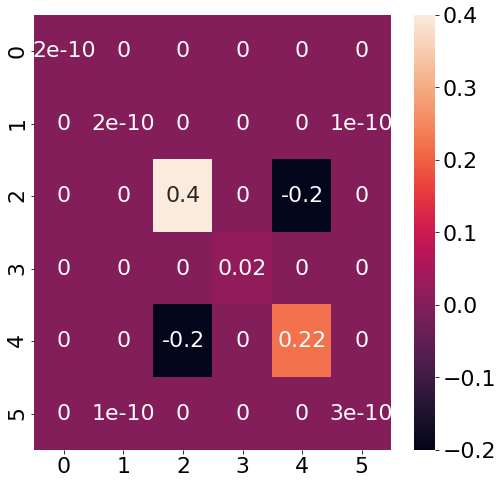

In [13]:
plt.figure(figsize=(8,8))
sns.heatmap(sigma,annot=True)

In [14]:
np.all(sigma == 0, axis=0)

array([False, False, False, False, False, False])

In [15]:
L = np.linalg.cholesky(sigma,)

<AxesSubplot:>

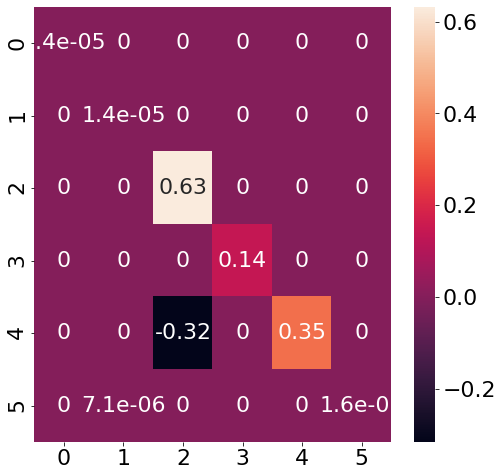

In [16]:
plt.figure(figsize=(8,8))
sns.heatmap(L,annot=True)

In [17]:
def cholesky(sigma):
    condition =~ (np.all(sigma == 0, axis=1) & (np.all(sigma == 0, axis=0)))
    m = [int(x) for x in condition]
    counter = 0
    res = []
    for el in m:
        if el > 0:
            res.append(counter)
            counter +=1
        else:
            res.append(None)
    M = []    
    for i in range(6):
        tmp = []
        for j in range(6):
            tmp.append([res[i],res[j]])
        
        M.append(tmp)
    M = np.array(M)
    
    block = (sigma[condition,:])[:,condition]

    L = np.linalg.cholesky(block)
    LL = np.zeros_like(sigma)
    
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if all(M[i,j] != None):
                k = M[i,j][0]
                l = M[i,j][1]
            
                LL[i,j] = L[k,l]
        
    return LL

In [18]:
sigma = np.diag([4,0,0.1,0.00,0.02,0])
A = cholesky(sigma)
print(A)

[[2.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.31622777 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.14142136 0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [19]:
np.linalg.norm(sigma - A@A.transpose())

0.0

In [20]:
N = 100
error = 0
for _ in range(N):
    tmp = np.random.randn(6)+5
    tmp[np.random.randint(0,6)] = 0
    sigma = np.diag(tmp)
    L = cholesky(sigma)
    error += np.linalg.norm(sigma - L@L.transpose())

print("Mean error: {}".format(error/N))

Mean error: 1.340672104382836e-15
